## import

In [1]:
import pandas as pd
import numpy as np
from math import exp

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

from yellowbrick.regressor import ResidualsPlot

import lime
import lime.lime_tabular

## df

In [2]:
df_registros_prod = pd.read_excel("../../dist/registros-prod.xlsx")
df_analise_preditiva = pd.read_excel("../../dist/analise-preditiva.xlsx")
df_analise_prescritiva = pd.read_excel("../../dist/analise-prescritiva.xlsx")

## functions & var

In [3]:
def fnc_Dummies(df):
    for cat_feature in df.select_dtypes(include=['object']).columns:
        df[cat_feature] = pd.Categorical(df[cat_feature]).codes
        df[cat_feature] = df[cat_feature].replace(-1,np.nan)
    return pd.DataFrame(df)

## 1. Análise Descritiva

In [4]:
# Feature de custo
var_custo = []
for index,row in df_registros_prod.iterrows():
    var_custo.append((200/(1+exp(10*(row['PESO_BOMBOM']-9.5))))+(200/(1+exp(-0.8*(row['PESO_BOMBOM']-12)))))
df_registros_prod['CUSTO'] = var_custo

# Features para modelos/gráficos
colunas = list(df_registros_prod.columns)
colunas_sem = colunas.copy()
colunas_sem.remove('PESO_BOMBOM')
colunas,colunas_sem

(['QTD_CHOC', 'VAR_1', 'VAR_2', 'PESO_BOMBOM', 'CUSTO'],
 ['QTD_CHOC', 'VAR_1', 'VAR_2', 'CUSTO'])

In [5]:
# Tipo de dados original
df_registros_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
QTD_CHOC       500 non-null float64
VAR_1          500 non-null float64
VAR_2          500 non-null object
PESO_BOMBOM    500 non-null float64
CUSTO          500 non-null float64
dtypes: float64(4), object(1)
memory usage: 19.6+ KB


In [6]:
# Conversão de variáveis categóricas
df_registros_prod_v2 = fnc_Dummies(df_registros_prod.copy())
df_registros_prod_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
QTD_CHOC       500 non-null float64
VAR_1          500 non-null float64
VAR_2          500 non-null int8
PESO_BOMBOM    500 non-null float64
CUSTO          500 non-null float64
dtypes: float64(4), int8(1)
memory usage: 16.2 KB


In [7]:
df_registros_prod_v2.head()

,QTD_CHOC,VAR_1,VAR_2,PESO_BOMBOM,CUSTO
0,320.15,0.88,0,10.144919,37.278717
1,320.14,1.55,0,11.547027,82.076805
2,284.85,2.97,0,11.112109,65.905963
3,263.92,2.36,2,9.900123,35.014600
4,276.22,2.98,2,10.079822,36.024115


In [8]:
# Descritiva básica de features
df_registros_prod_v2.describe()

,QTD_CHOC,VAR_1,VAR_2,PESO_BOMBOM,CUSTO
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,291.264600,2.098180,1.038000,10.395002,107.161983
std,45.182499,0.711166,0.818472,1.572233,65.647587
min,112.910000,0.050000,0.000000,4.543124,34.690631
25%,259.267500,1.630000,0.000000,9.425819,49.183556
50%,295.450000,2.300000,1.000000,10.334273,82.358225
75%,325.137500,2.672500,2.000000,11.379932,173.128378
max,436.070000,2.980000,2.000000,17.362728,215.271798


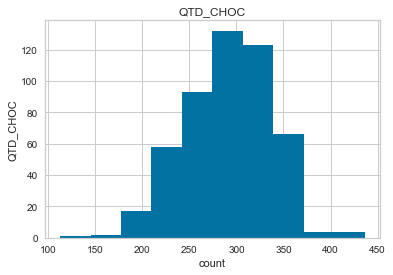

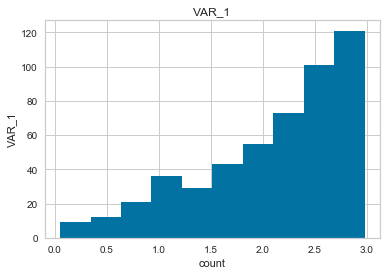

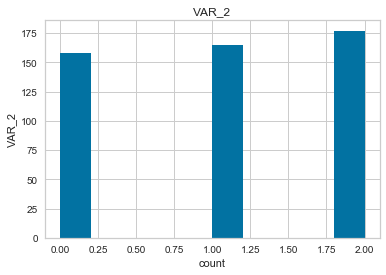

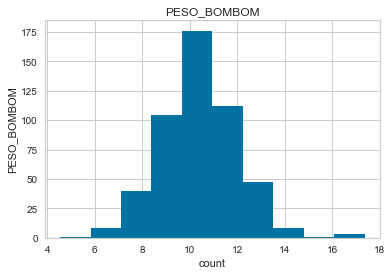

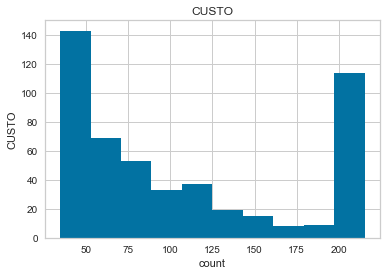

In [9]:
# Histogramas
for coluna in colunas:
    fig, ax = plt.subplots()
    plt.hist(df_registros_prod_v2[coluna])
    plt.ylabel(coluna)
    plt.xlabel('count')
    plt.title(coluna)

Text(0.5,1,'TOLERÂNCIA ATUAL')

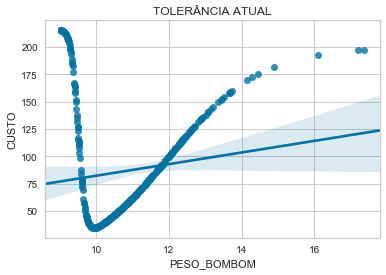

In [10]:
# RECOMENDAÇÃO ATUAL
features_limite_inf = colunas
df_limite_inf = df_registros_prod_v2[features_limite_inf].copy()
df_limite_inf = df_limite_inf[(df_limite_inf['PESO_BOMBOM']>=9)]

sns.regplot(x='PESO_BOMBOM',y='CUSTO', data=df_limite_inf).set_title("TOLERÂNCIA ATUAL")

In [11]:
df_limite_inf.describe()

,QTD_CHOC,VAR_1,VAR_2,PESO_BOMBOM,CUSTO
count,417.000000,417.000000,417.000000,417.000000,417.000000
mean,296.617314,2.244149,0.973621,10.854823,86.815113
std,43.972990,0.634354,0.855848,1.254683,51.638288
min,178.150000,0.080000,0.000000,9.028357,34.690631
25%,264.760000,1.940000,0.000000,9.931499,45.206657
50%,300.530000,2.430000,1.000000,10.654463,70.122535
75%,331.570000,2.740000,2.000000,11.561550,113.899914
max,436.070000,2.980000,2.000000,17.362728,215.210262


22.2% das amostras (111): >= 9.7 & <= 10.5


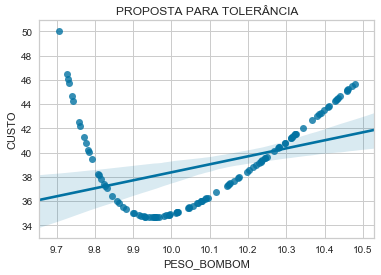

In [12]:
# RECOMENDAÇÃO PROPOSTA
# TOLERÂNCIA
limite_inferior_perc = 10-(0.03*10)
limite_superior_perc = 10+(0.05*10)

features_limite = colunas
df_limite = df_registros_prod_v2[features_limite].copy()
df_limite_v2 = df_limite[
    (df_limite['PESO_BOMBOM']>=limite_inferior_perc) &
    (df_limite['PESO_BOMBOM']<=limite_superior_perc)
].copy()

sns.regplot(x='PESO_BOMBOM',y='CUSTO', data=df_limite_v2).set_title("PROPOSTA PARA TOLERÂNCIA")
print(
    str(round(len(df_limite_v2)/len(df_limite)*100,2))+
    '% das amostras ('+
    str(len(df_limite_v2))+
    '): >= '+str(limite_inferior_perc)+
    ' & <= '+str(limite_superior_perc)
)

In [13]:
df_limite_v2.describe()

,QTD_CHOC,VAR_1,VAR_2,PESO_BOMBOM,CUSTO
count,111.000000,111.000000,111.000000,111.000000,111.000000
mean,279.575135,2.283694,1.459459,10.091967,38.983600
std,39.044730,0.638566,0.735883,0.222271,3.747397
min,200.810000,0.230000,0.000000,9.706635,34.690631
25%,252.620000,2.045000,1.000000,9.923738,35.474519
50%,276.090000,2.480000,2.000000,10.076711,38.273099
75%,305.040000,2.725000,2.000000,10.281426,41.514407
max,414.610000,2.980000,2.000000,10.478211,50.018230


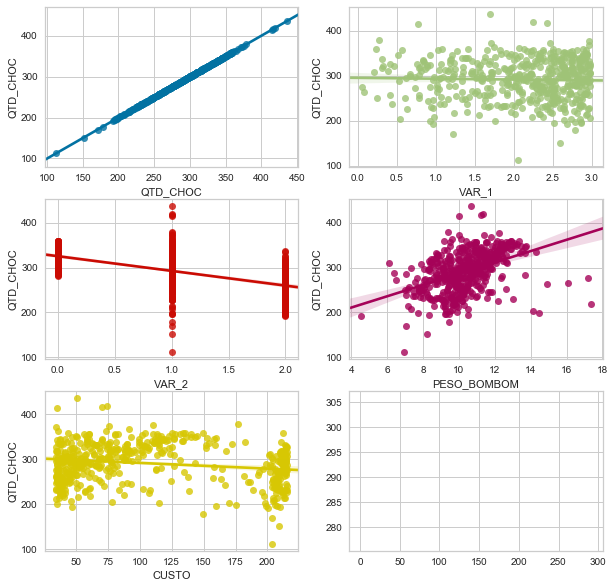

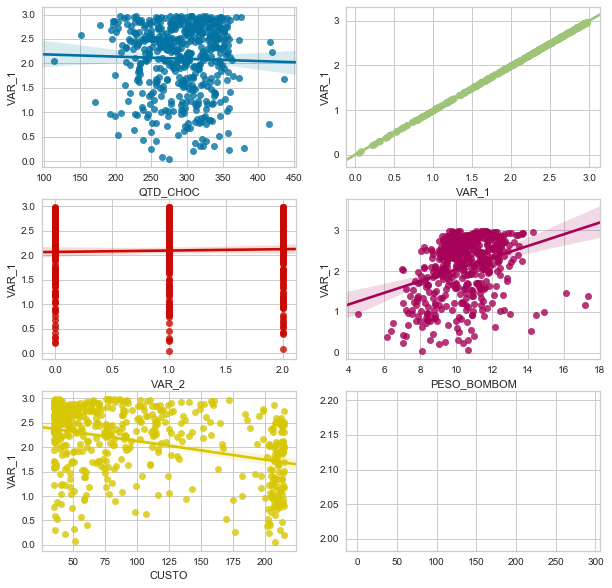

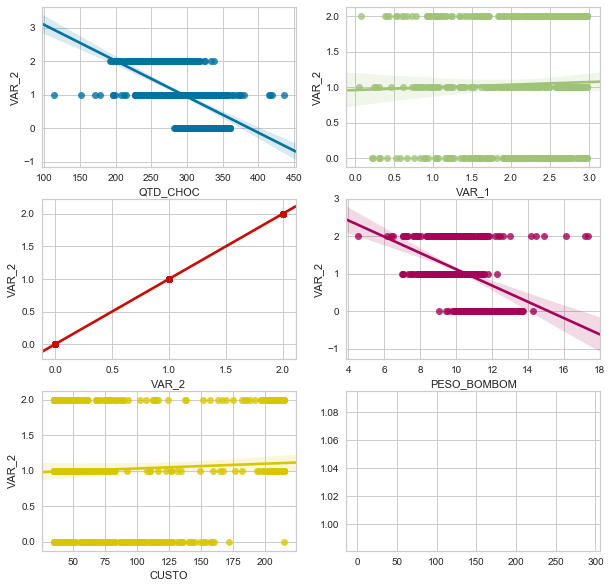

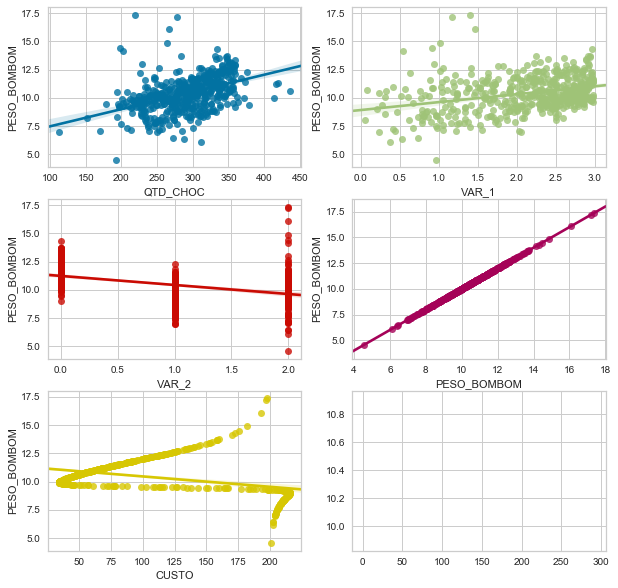

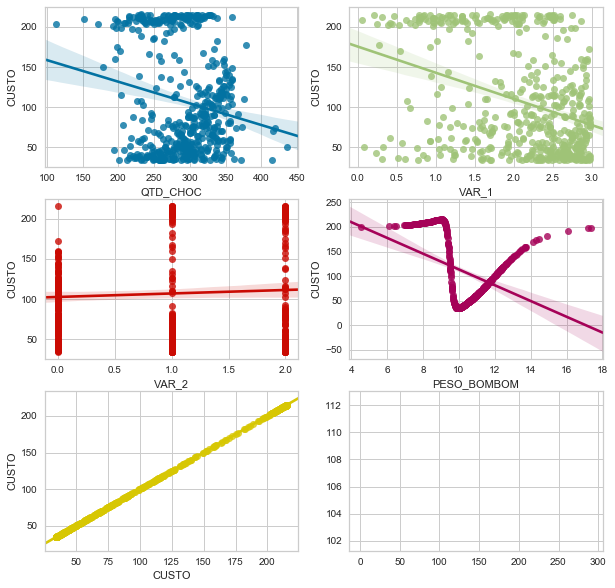

In [14]:
# Regressão Linear Simples (todos vs todos)
for var_interesse in colunas:
    features_to_analyse = colunas
    fig, ax = plt.subplots(3, 2, figsize = (10,10))
    for i, ax in enumerate(fig.axes):
        if i < len(features_to_analyse):
            sns.regplot(x=features_to_analyse[i],y=var_interesse, data=df_registros_prod_v2[features_to_analyse], ax=ax)

## 2. Análise Diagnóstica

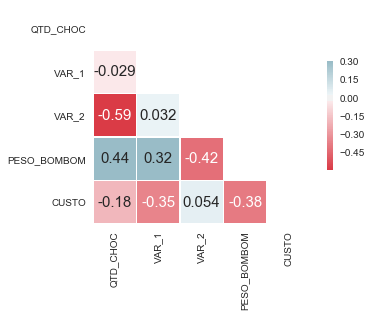

In [15]:
# Matriz de Correlação de Pearson
corr = df_registros_prod_v2.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots()

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, annot_kws={"size": 15}, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [16]:
corr

,QTD_CHOC,VAR_1,VAR_2,PESO_BOMBOM,CUSTO
QTD_CHOC,1.000000,-0.029062,-0.591910,0.437217,-0.184706
VAR_1,-0.029062,1.000000,0.032482,0.316657,-0.352085
VAR_2,-0.591910,0.032482,1.000000,-0.416718,0.053996
PESO_BOMBOM,0.437217,0.316657,-0.416718,1.000000,-0.384280
CUSTO,-0.184706,-0.352085,0.053996,-0.384280,1.000000


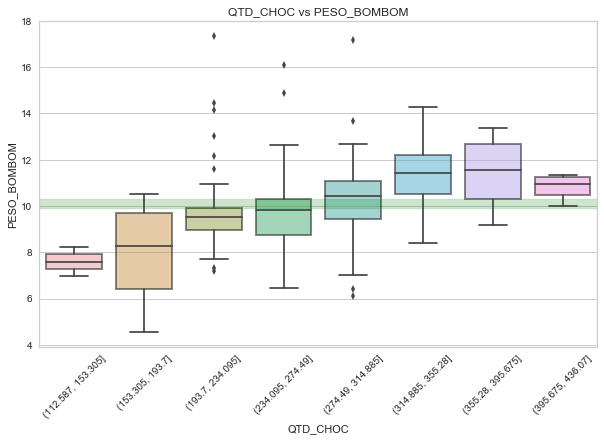

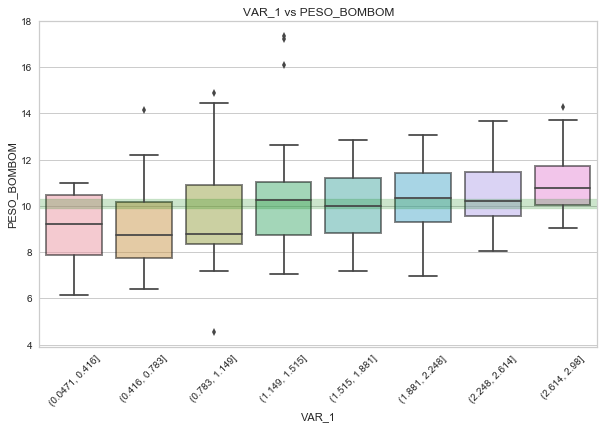

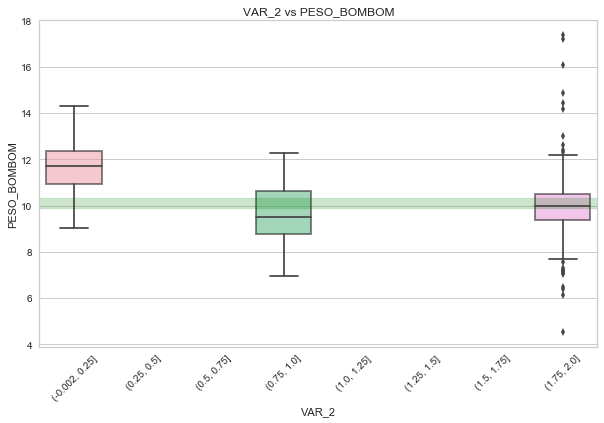

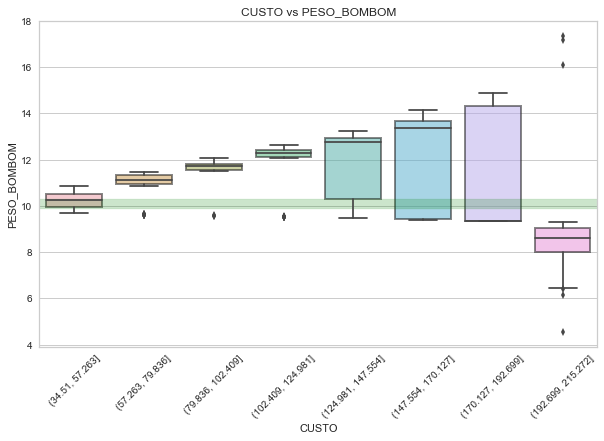

In [17]:
# Boxplot com bucket/8 + faixa ideal para peso
limites =[['QTD_CHOC',240,318],['VAR_1',1.6,2.9],['VAR_2',0.7,2],['PESO_BOMBOM',9.87,10.31],['CUSTO',35.24,42.73]]

for var_boxplot in colunas_sem:    
    plt.figure(figsize = (10, 6))
    ax = sns.boxplot(x=pd.cut(df_registros_prod_v2[var_boxplot], 8), y='PESO_BOMBOM', data=df_registros_prod_v2)
    
    # Faixa recomendada peso
    rect = plt.Rectangle((-1,9.87),100,10.31-9.87,color='green', alpha=0.2, ec='green')
    ax.add_patch(rect)
    
    ax.set_title(str(var_boxplot+' vs PESO_BOMBOM'))    
    plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
    plt.xticks(rotation=45)

## 3. Análise Preditiva - Sem 'CUSTO'

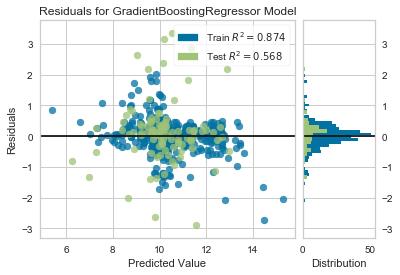

In [18]:
# Modelo preditivo - GradientBoostingRegressor
df_mqo_v3_sc = df_registros_prod_v2.copy()

# Remove custo
colunas_pred = colunas_sem.copy()
colunas_pred.remove('CUSTO')

# Variáveis para treino
feature_names = colunas_pred
target_name = ['PESO_BOMBOM']

X = df_mqo_v3_sc[feature_names]
y = df_mqo_v3_sc[target_name].values.ravel()

# Separa dados para treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=50)

# Prepara modelo para gráfico
model_sc = GradientBoostingRegressor()
visualizer = ResidualsPlot(model_sc)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

In [19]:
# Mean squared error
train_model = model_sc.fit(X,y)
y_true = y
y_pred = train_model.predict(X)
print('MSE: ', mean_squared_error(y_true, y_pred))

MSE:  0.345853058917026


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002C131DD9080>,
      dtype=object)

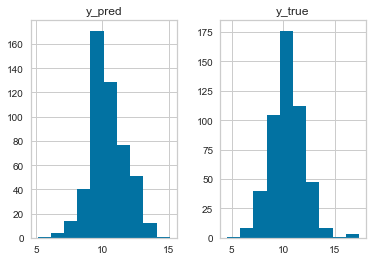

In [20]:
# Comparativo
df_metric = pd.DataFrame(columns=['y_true','y_pred'])
df_metric['y_true'] = y_true
df_metric['y_pred'] = y_pred
df_metric.hist()

In [21]:
# Faz cópia de dataset
df_analise_preditiva_v2 = fnc_Dummies(df_analise_preditiva)

# Variáveis para predict
feature_names = colunas_pred
X_2 = df_analise_preditiva_v2[feature_names]

# Carrega modelo para predict
df_analise_preditiva_v2['PESO_BOMBOM'] = model_sc.predict(X_2)

In [22]:
df_analise_preditiva_v2.describe()

,QTD_CHOC,VAR_1,VAR_2,PESO_BOMBOM
count,50.000000,50.000000,50.000000,50.000000
mean,294.613400,2.191200,1.040000,10.269148
std,42.792363,0.632225,0.754848,1.140194
min,208.000000,0.630000,0.000000,8.033647
25%,265.457500,1.902500,0.250000,9.572751
50%,295.120000,2.320000,1.000000,9.997257
75%,320.142500,2.727500,2.000000,10.959749
max,387.760000,2.980000,2.000000,13.028284


In [23]:
# Salva predições
writer = pd.ExcelWriter('../../dist/analise-preditiva-new.xlsx', engine='xlsxwriter')
df_analise_preditiva_v2.to_excel(writer, sheet_name='Sheet1', index=False)
writer.save()

## Bônus - lime

In [24]:
# Preparando modelo Lime
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=list(X_train.columns), 
    class_names=var_interesse,
    verbose=True, 
    mode='regression'
)

# Define seed para modelo
def explain(instance, predict_fn, **kwargs):
  np.random.seed(50)
  return explainer.explain_instance(instance, predict_fn, **kwargs)

# Modelo de predição para teste
i = 99
exp = explain(X_test.values[i], train_model.predict, num_features=3)

Intercept 10.001450760807737
Prediction_local [11.19749592]
Right: 11.761992604554484


In [25]:
# Resultados
exp.show_in_notebook(show_table=True)

## 4. Análise Prescritiva